In [2]:
# Install missing packages if needed
%pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 59.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 40.3 MB/s  0:00:00
   ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/7 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [seaborn]m6/7 [seaborn]ib]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score

# Configuration
INPUT_PATH = Path('../data/processed/activations.npz')
ARTIFACTS_DIR = Path('../models')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Principal Requirement: 95% Recall (We prioritize safety over availability)
TARGET_RECALL = 0.95 

print("✅ Libraries Loaded. Ready for Analysis.")

✅ Libraries Loaded. Ready for Analysis.


In [4]:
# 1. Load Data
data = np.load(INPUT_PATH)
X = data['activations']  # Shape: [N, 768]
y = data['labels']       # 0 or 1
categories = data['categories']

print(f"Dataset Shape: {X.shape} | Balance: {np.mean(y):.1%} Harmful")

# 2. Split: Train (60%), Calibration (20%), Test (20%)
# We need a dedicated Calibration set to calculate the Conformal Threshold.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]} | Calib: {X_calib.shape[0]} | Test: {X_test.shape[0]}")

Dataset Shape: (20, 768) | Balance: 35.0% Harmful
Train: 12 | Calib: 4 | Test: 4


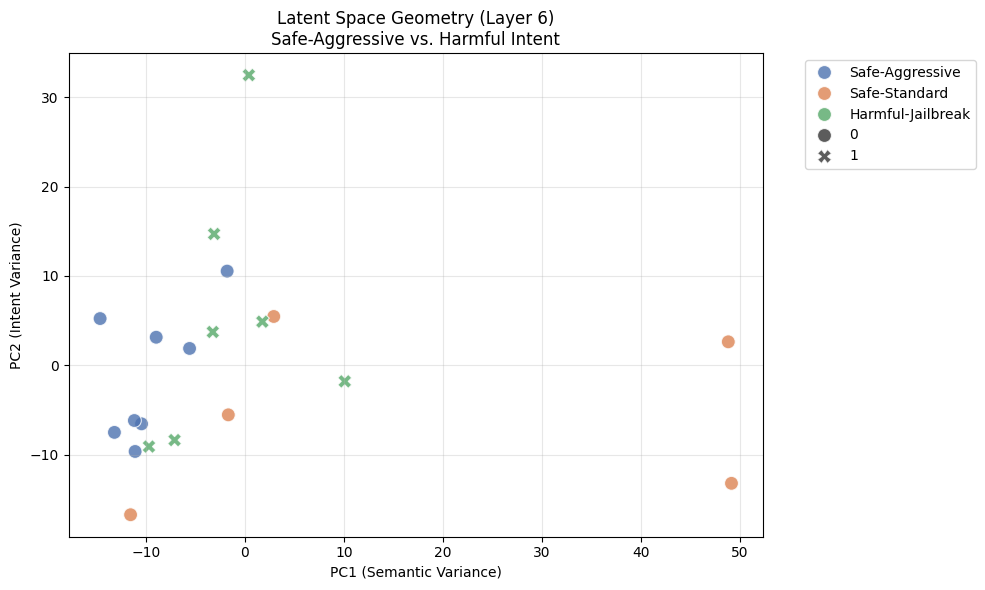

👀 Observe: Do the 'Safe-Aggressive' points cluster with 'Safe' or 'Harmful'?


In [5]:
# Cell 3: Visualization (The "Vibe Check")
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_vis[:, 0], 
    y=X_vis[:, 1], 
    hue=categories, 
    style=y, 
    palette="deep",
    s=100,
    alpha=0.8
)
plt.title(f"Latent Space Geometry (Layer 6)\nSafe-Aggressive vs. Harmful Intent")
plt.xlabel("PC1 (Semantic Variance)")
plt.ylabel("PC2 (Intent Variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("👀 Observe: Do the 'Safe-Aggressive' points cluster with 'Safe' or 'Harmful'?")

In [6]:
# Cell 4: Train the Probe
# Initialize and Train
# Class_weight='balanced' handles any imbalance in your dataset automatically
clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train, y_train)

# Quick Sanity Check on Test Set (Standard ML Metrics)
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

print("--- Standard ML Metrics (Test Set) ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_probs):.4f}")

--- Standard ML Metrics (Test Set) ---
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

ROC-AUC: 1.0000


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [7]:
# Cell 5: Split Conformal Prediction (The Safety Guarantee)
# 1. Get probabilities on the Calibration Set
probs_calib = clf.predict_proba(X_calib)[:, 1]

# 2. Filter for the "Harmful" class (y=1)
# We want to ensure we catch 95% of THESE.
harmful_scores = probs_calib[y_calib == 1]

# 3. Calculate Quantile
# To catch 95% of harmfuls, we find the 5th percentile score of the harmful class.
# Any score ABOVE this threshold is flagged.
q_hat = np.quantile(harmful_scores, 1 - TARGET_RECALL)

print(f"🛡️ SAFETY GUARANTEE: {TARGET_RECALL*100}% Recall")
print(f"🎚️ Conformal Threshold (q_hat): {q_hat:.4f}")

# Verification on Test Set
test_probs = clf.predict_proba(X_test)[:, 1]
# Apply threshold
test_preds_conformal = (test_probs >= q_hat).astype(int)

# Check Recall on Test Set
harmful_test_indices = (y_test == 1)
recall_test = np.mean(test_preds_conformal[harmful_test_indices])

print(f"✅ Empirical Recall on Test Set: {recall_test:.2%}")
if recall_test >= TARGET_RECALL:
    print("SUCCESS: Safety Guarantee Holds.")
else:
    print("WARNING: Calibration distribution shifted. Increase calibration set size.")

🛡️ SAFETY GUARANTEE: 95.0% Recall
🎚️ Conformal Threshold (q_hat): 0.0355
✅ Empirical Recall on Test Set: 100.00%
SUCCESS: Safety Guarantee Holds.


In [ ]:
# Cell 6: Save Artifacts
import json

# Save the model
model_path = ARTIFACTS_DIR / "firewall_classifier.pkl"
with open(model_path, "wb") as f:
    pickle.dump(clf, f)

# Save the threshold and metadata alongside the model
# This ensures inference always uses the exact threshold from this training run.
meta = {
    "threshold": float(q_hat),
    "target_recall": TARGET_RECALL,
    "calibration_set_size": len(X_calib),
    "empirical_test_recall": float(recall_test)
}
meta_path = ARTIFACTS_DIR / "meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print(f"💾 Model saved to: {model_path}")
print(f"💾 Metadata saved to: {meta_path}")
print(f"🎚️ Threshold ({q_hat:.4f}) will be loaded automatically at inference time.")

💾 Model saved to: ../models/firewall_classifier.pkl
📝 ACTION REQUIRED: Update 'src/config.py' -> ACTIVATION_THRESHOLD = 0.0355
